In [1]:
%matplotlib notebook
import numpy as np
import numpy.random
import scipy.stats as ss
import matplotlib.pyplot as plt

In [2]:
# Set-up.
n = 10000

num_bins = 100

# Parameters of the mixture components
# E.g. first Normal, mean = 5 and variance = 1.
norm_params = np.array([[5, 1],
                        [1, 1.3],
                        [9, 1.3]])

# Weight of each component
weights = np.array([1, 1, 1])
weights = weights/np.sum(weights)

# Number of components.
assert len(weights) == norm_params.shape[0]
n_components = norm_params.shape[0]

<IPython.core.display.Javascript object>


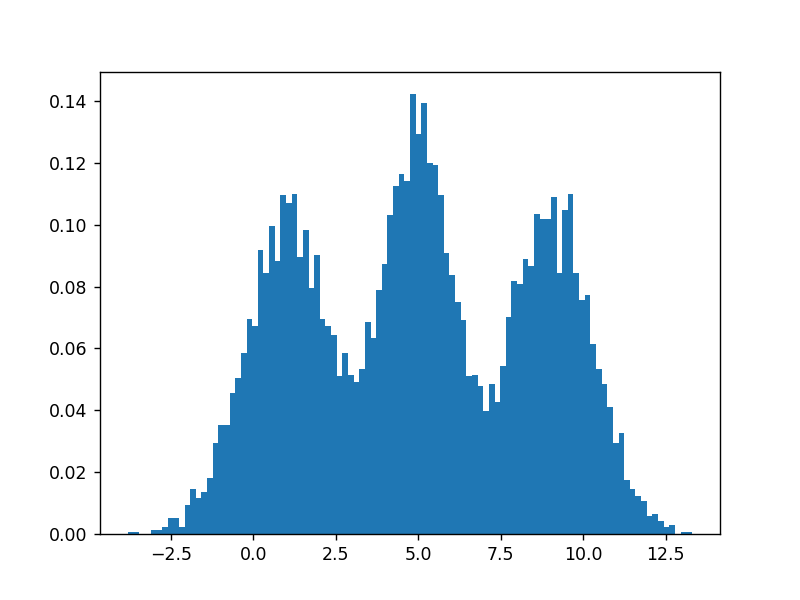

In [3]:
"""
Approach 1
"""
# Step1, assign each point to a certrain Gaussian distribution
# A stream of indices from which to choose the component
mixture_idx = numpy.random.choice(n_components, size=n, replace=True, p=weights)

# Step 2: draw r.v. from signle normal distributions.
# y is the mixture sample
y = numpy.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx), dtype=np.float64)

fig, ax = plt.subplots()

# the histogram of the data
_ = ax.hist(y, num_bins, density=1)

(3, 10000)


<IPython.core.display.Javascript object>


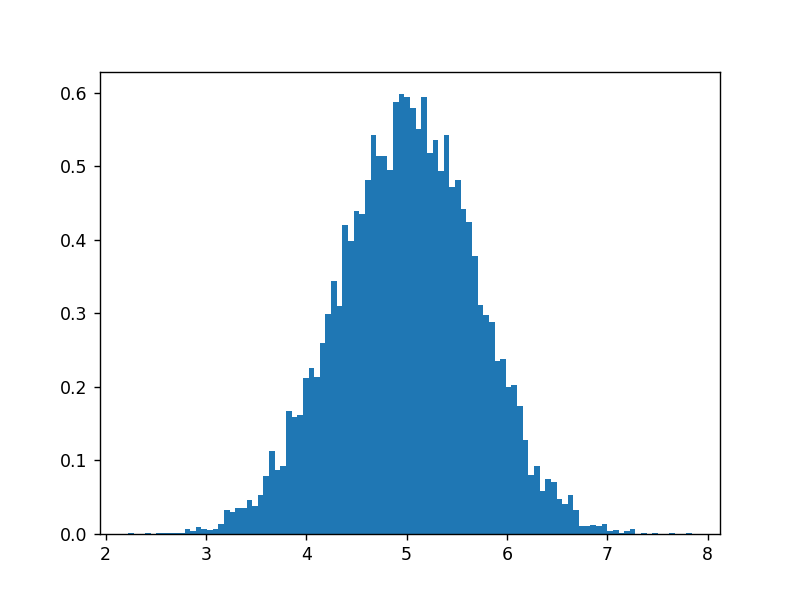

In [4]:
"""
Approach 2
"""

# Step1, generate N random variables from each single Normal distribution
Random_Variables = np.array([ss.norm.rvs(loc = norm_params[i][0], scale = norm_params[i][1], size=n) for i in range(n_components)])
print(Random_Variables.shape)


# Step 2: Treate it as a weighted sum
y = weights @ Random_Variables


fig, ax = plt.subplots()

# the histogram of the data
_ = ax.hist(y, num_bins, density=1)